<a href="https://colab.research.google.com/github/kaylaque/EMG/blob/main/algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Explanation

ToDoList


*   get reference on algorithm best for EMG
*   search to know other way to visualize better
*   set to save as csv
*   put Feature Selection codes



# Preparation

In [ ]:
#  loading modules

# generic libraries
import numpy as np
import itertools
import time
import random

# library for loading in matlab files
import scipy.io as sio

# loading data from web libraries
import requests
import io
import zipfile

# time series function from the statsmodels library
from statsmodels.tsa.ar_model import AR

# general machine learning functions from the sklearn library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# machine learning model functions
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

# dimensionality reduction functions
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# plotting library
import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.mlab import find

import matplotlib.patches as mpatches


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data Loading

In [ ]:
# get hand data from web and put in your working directory
req = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00313/sEMG_Basic_Hand_movements_upatras.zip")
z = zipfile.ZipFile(io.BytesIO(req.content))
z.extractall()

In [ ]:
######################################################################################################################
# loading functions
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res

def load_hand_signals_five_subjects():
    '''
    This function loads data from Database 1 which contains
    all the sEMG signals for the experiment with five subjects.
    
    Import each subject's dictionaries into one list
    Remove any metadata in the dictionaries
    '''
    subject_signals = []
    
    signal_1 = sio.loadmat("./Database 1/female_1.mat")
    del signal_1['__header__'] # remove metadata
    del signal_1['__globals__']
    del signal_1['__version__']
    subject_signals.append(signal_1)
    signal_2 = sio.loadmat("./Database 1/female_2.mat")
    del signal_2['__header__'] 
    del signal_2['__globals__']
    del signal_2['__version__']
    subject_signals.append(signal_2)
    signal_3 = sio.loadmat("./Database 1/female_3.mat")
    del signal_3['__header__'] 
    del signal_3['__globals__']
    del signal_3['__version__']
    subject_signals.append(signal_3)

    signal_4 = sio.loadmat("./Database 1/male_1.mat")
    del signal_4['__header__'] 
    del signal_4['__globals__']
    del signal_4['__version__']
    subject_signals.append(signal_4)
    signal_5 = sio.loadmat("./Database 1/male_2.mat")
    del signal_5['__header__'] 
    del signal_5['__globals__']
    del signal_5['__version__']
    subject_signals.append(signal_5)
    
    return subject_signals

def load_hand_signals_one_subject():
    '''
    This function loads data from Database 2 which contains
    all the sEMG signals for the experiment with a single male subject
    
    Import each subject's dictionaries into one list
    Remove any metadata in the dictionaries
    '''
    subject_signals = []
    
    signal_1 = sio.loadmat("./Database 2/male_day_1.mat")
    
    n = len(signal_1.keys())
    
    subject_signals.append(dict(itertools.islice(signal_1.items(),3,n))) # the three removes the hand metadata
    
    signal_2 = sio.loadmat("./Database 2/male_day_2.mat")
    subject_signals.append(dict(itertools.islice(signal_2.items(),3,n))) 
    
    signal_3 = sio.loadmat("./Database 2/male_day_3.mat")
    subject_signals.append(dict(itertools.islice(signal_3.items(),3,n)))
 
    return subject_signals

def get_signal_classes(subject_signals,num_trials):
    '''
    returns a list of classes where the ith element is the class of 
    the ith signal from the subject_signals dictionary. 
    
    Note: this function returns the specific class and channel of a signal
    '''
    n = len(subject_signals)
    all_signals_classes = []
    
    for i in range(n):

        current_subject = subject_signals[i]
        class_keys = list(current_subject.keys())
        
        # repeat each class num_trails times
        repeated_list = list(itertools.chain.from_iterable(itertools.repeat(x, num_trials) for x in class_keys))
        all_signals_classes.extend(repeated_list) 
        
    return all_signals_classes

def get_combined_channel_classes(num_trials,num_sessions):
    '''
    returns a list of combined channel classes for the hand signals. This
    function is invoked independent of the subject_signals dictionary and is 
    written so that the ith signal in the feature vector of signals x has its ith
    class being the ith element of the y returned by this function.
    '''
    y = []
    class_keys_new = ['cyl','hook','tip','palm','spher','lat']
    for i in range(num_sessions):
        repeated_list = list(itertools.chain.from_iterable(itertools.repeat(x, num_trials) for x in class_keys_new))
        y.extend(repeated_list)
    return y

def segment_signal(signal, window_length = 4, overlap_length = 2, copy = False):
    '''
    segment a signal into windows of size window_length and which overlap with
    size overlap_length. This function returns an array which contains these segments
    as subarrays.
    '''
    sh = (signal.size - window_length + 1, window_length)
    st = signal.strides * 2
    
    # numpy trick for fast segmentation
    view = np.lib.stride_tricks.as_strided(signal, strides = st, shape = sh)[0::overlap_length] 
    if copy:
        return view.copy()
    else:
        return view


In [ ]:
one_subject = load_hand_signals_one_subject()
five_subject = load_hand_signals_five_subjects()

In [ ]:
print(len(one_subject))
print(len(one_subject[2]))
print(len(one_subject[2]['spher_ch2'][0]))
print(one_subject[0].keys())

3
12
2500
dict_keys(['cyl_ch1', 'cyl_ch2', 'hook_ch1', 'hook_ch2', 'tip_ch1', 'tip_ch2', 'palm_ch1', 'palm_ch2', 'spher_ch1', 'spher_ch2', 'lat_ch1', 'lat_ch2'])


In [ ]:
five_subject[2]['spher_ch2'][0]

array([ 0.253201,  0.15117 ,  0.227693, ...,  0.15117 , -0.614063,
       -0.358985])

In [ ]:
print(len(five_subject))
print(len(five_subject[2]))
print(len(five_subject[2]['spher_ch2'][0]))

5
12
3000


In [ ]:
one_subject[0].keys()

dict_keys(['cyl_ch1', 'cyl_ch2', 'hook_ch1', 'hook_ch2', 'tip_ch1', 'tip_ch2', 'palm_ch1', 'palm_ch2', 'spher_ch1', 'spher_ch2', 'lat_ch1', 'lat_ch2'])

In [ ]:
# for move in data:
  

#Visualization

In [ ]:
###############################################################################################################
# visualization and dimensionality reduction
    
def visualization(x,y,num_classes,legend=True, method="tsne"):
     '''
     Uses dimensionality reduction to visualize a feature matrix x and class vector y. This
     function colors each class a different color and if legend=TRUE, 
     the plot includes a legend which shows which class each color represents. 
     
     Note: suppored methods are t-sne and pca. 
     '''
     mydict = {} # this first chunk of code encodes class strings as numbers
     i = 0
     for item in y:
         if(i>0 and item in mydict):
             continue
         else:    
            i = i+1
            mydict[item] = i

     k=[]
     for item in y:
         k.append(mydict[item])
    
     if method == "tsne":
         Y = TSNE(2,init='pca').fit_transform(x) # TSNE function is from sklearn.manifold
         
     elif method == "pca":
         Y = PCA(2).fit_transform(x)    
         
     colors = ['red','green','blue','purple','yellow','black',
                   'pink','violet','teal','orchid','lime','cyan','gold','silver','magenta']
     colors = colors[:num_classes]
     plt.scatter(Y[:,0], Y[:,1], c=k, cmap=matplotlib.colors.ListedColormap(colors))     
     frame1 = plt.gca() # gca, gcf used to manipute axes and plot size 
     frame2 = plt.gcf()
     
     frame1.axes.xaxis.set_ticklabels([])  # hide the axis labels and tick marks since they are irrelevant for tsne and pca visualizations
     frame1.axes.yaxis.set_ticklabels([])
     frame1.axes.xaxis.set_ticks([])
     frame1.axes.yaxis.set_ticks([])
     frame2.set_size_inches(10, 10) 
     if legend == True:

         unique_classes = [e for i, e in enumerate(y) if y.index(e) == i]
         recs=[]
         for i in range(0,len(colors)):
             recs.append(mpatches.Rectangle((0,0),1,1,fc=colors[i])) # manually add legend

         plt.legend(recs,unique_classes,loc=0,fontsize = 'large') # put legend in 'best' location

     plt.show()
     
def combine_channels(x,num_trials):
    '''
    combines the hand data channels; for instance, cyl_ch1 and cyl_ch2
    turn into cyl. The features vector of cyl_ch1 is appended onto
    the end of feature vector of cyl_ch2 to get feature vector of cyl
    '''
    n = len(x)
    x_new = [0]*int((n/2)) # new list will be half the size
    i = 0
    k = 0
    while i != n: 
        x_new[k]= x[i]+x[i+num_trials]
        i += 1
        k += 1
        if (i+num_trials) % num_trials == 0:
            i = i+num_trials
    return x_new


In [ ]:
five_subject[0].keys()

dict_keys(['cyl_ch1', 'cyl_ch2', 'hook_ch1', 'hook_ch2', 'tip_ch1', 'tip_ch2', 'palm_ch1', 'palm_ch2', 'spher_ch1', 'spher_ch2', 'lat_ch1', 'lat_ch2'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently

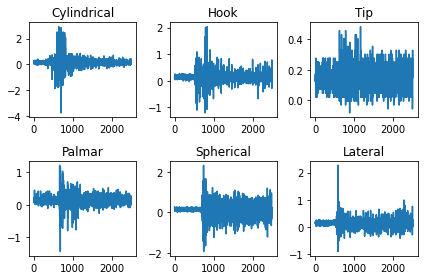

In [ ]:
# plt.plot(one_subject[0]['spher_ch1'][0,:])
fig = plt.figure()
plt.subplot(2, 3, 1)
plt.subplot(2, 3, 1).set_title('Cylindrical')
plt.plot(one_subject[0]['cyl_ch1'][0,:])
plt.subplot(2, 3, 2)
plt.subplot(2, 3, 2).set_title('Hook')
plt.plot(one_subject[0]['hook_ch1'][0,:])
plt.subplot(2, 3, 3)
plt.subplot(2, 3, 3).set_title('Tip')
plt.plot(one_subject[0]['tip_ch1'][0,:])
plt.subplot(2, 3, 4)
plt.subplot(2, 3, 4).set_title('Palmar')
plt.plot(one_subject[0]['palm_ch1'][0,:])
plt.subplot(2, 3, 5)
plt.subplot(2, 3, 5).set_title('Spherical')
plt.plot(one_subject[0]['spher_ch1'][0,:])
plt.subplot(2, 3, 6)
plt.subplot(2, 3, 6).set_title('Lateral')
plt.plot(one_subject[0]['lat_ch1'][0,:])
fig.tight_layout()  

# Preprocessing


In [ ]:
from scipy import signal

In [ ]:
def lfilter(inp, order): # defining Lfilter
    nyq = 1000 / 2.0
    low = 47 / nyq 
    high = 53/ nyq
    b, a = signal.iirfilter(order,[low,high ], btype='bandstop',ftype='butter')
    output = signal.lfilter(b, a, inp)
    return output

In [ ]:
def iirfilter(inp, order): #defining iirfilter   (we will not use it , putting it for illustration)
    
    b, a = signal.iirfilter(order, [47/1000, 53/1000], btype='bandstop')
    output = signal.freqs(b, a, inp)
    return output

In [ ]:
#example
palmar_filtered=lfilter(inp=one_subject[0]['palm_ch1'],order=6)
lateral_filtered=lfilter(inp=one_subject[0]['lat_ch1'],order=6)
lateral_filtered.shape

(100, 2500)

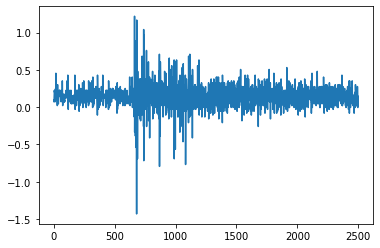

In [ ]:
plt.plot(one_subject[0]['palm_ch1'][0,:])

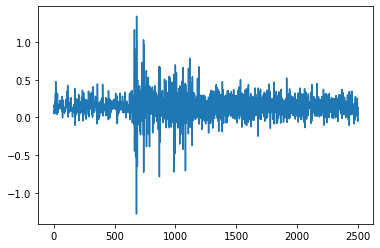

In [ ]:
plt.plot(palmar_filtered[0,:]) #ploting the first row of palmar after applying filter

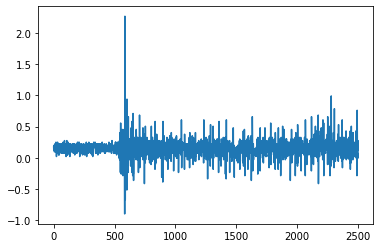

In [ ]:
plt.plot(one_subject[0]['lat_ch1'][0,:])

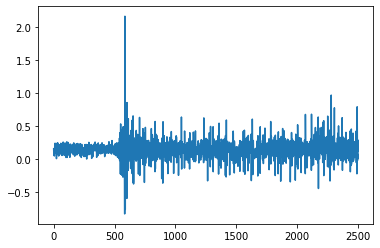

In [ ]:
plt.plot(lateral_filtered[0,:]) #ploting the first row of palmar after applying filter

On Paper titled: A new framework for classification of multi-category hand grasps using EMG signals

Method used: LSGS, AdaBoost K-means, ensemble feature selection

1. LSGS: Short time fourier transform-> absolute(STFT result)-> log(abs(STFT result))
2. AdaBoost K-Means
3. Ensemble Feature Selection


In [ ]:
from scipy.signal import stft
# stft_sig = stft(x, fs=1.0, window='hann', nperseg=256, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)
def lsgs(emg):
  f, t, Zxx = stft(emg, fs=1.0, nperseg=1000)
  sig = np.log10(np.abs(Zxx))  
  return(sig)

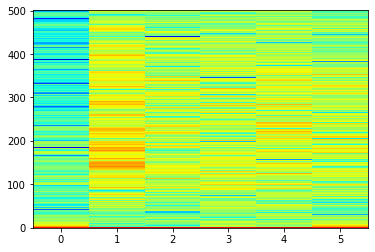

In [ ]:
img = plt.imshow(lsgs, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
plt.show()

Mean Removed

In [ ]:
# if using IPython: check variables from previous lesson are still in workspace
# %whos

# process EMG signal: remove mean
def mean(emg):
  emg_correctmean = emg - np.mean(emg)
  return(emg_correctmean)

Filter EMG signal

In [ ]:
import scipy as sp
from scipy import signal

def filter(emg):
  # create bandpass filter for EMG
  high = 20/(1000/2)
  low = 450/(1000/2)
  b, a = sp.signal.butter(4, [high,low], btype='bandpass')

  # process EMG signal: filter EMG
  emg_filtered = sp.signal.filtfilt(b, a, emg)
  return(emg_filtered)

Rectified EMG

In [ ]:
def rectify(emg):
  # process EMG signal: rectify
  emg_rectified = abs(emg)
  return(emg_rectified)

In [ ]:
processed_emg = []
for j in range(len(five_subject)):
  a_subject = dict.fromkeys(five_subject[j].keys(), [])
  for i in five_subject[j].keys():
    a_subject[i] = lsgs(five_subject[j][i][:,:])
    
  processed_emg.append(a_subject)

In [ ]:
plt.pcolormesh(t, f, lsgs, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
len(a_subject['palm_ch2'])

30

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently

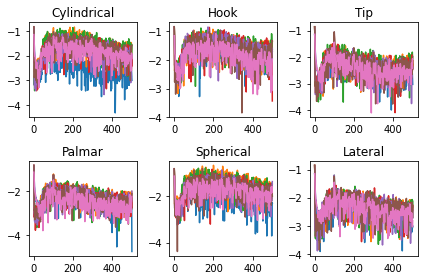

In [ ]:
# plt.plot(one_subject[0]['spher_ch1'][0,:])
fig = plt.figure()
plt.subplot(2, 3, 1)
plt.subplot(2, 3, 1).set_title('Cylindrical')
plt.plot(processed_emg[0]['cyl_ch1'][0, :])
plt.subplot(2, 3, 2)
plt.subplot(2, 3, 2).set_title('Hook')
plt.plot(processed_emg[0]['hook_ch1'][0, :])
plt.subplot(2, 3, 3)
plt.subplot(2, 3, 3).set_title('Tip')
plt.plot(processed_emg[0]['tip_ch1'][0, :])
plt.subplot(2, 3, 4)
plt.subplot(2, 3, 4).set_title('Palmar')
plt.plot(processed_emg[0]['palm_ch1'][0, :])
plt.subplot(2, 3, 5)
plt.subplot(2, 3, 5).set_title('Spherical')
plt.plot(processed_emg[0]['spher_ch1'][0, :])
plt.subplot(2, 3, 6)
plt.subplot(2, 3, 6).set_title('Lateral')
plt.plot(processed_emg[0]['lat_ch1'][0, :])
fig.tight_layout()  

In [ ]:
processed_emg

In [ ]:
print(len(processed_emg))
print(len(processed_emg[2]))
print(len(processed_emg[2]['spher_ch2'][0]))
print(len(five_subject))
print(len(five_subject[2]))
print(len(five_subject[2]['spher_ch2'][0]))
# for j in range(len(processed_emg)):
#   for i in processed_emg[2].keys():
#     print(type(processed_emg[j][i][:][:]))
#     np.int32(processed_emg[j][i][:][:])

5
12
501
5
12
3000


In [ ]:

# plot comparison of unfiltered vs filtered mean-corrected EMG
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.subplot(1, 2, 1).set_title('Unfiltered EMG')
plt.plot(emg_correctmean)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.ylim(-1.5, 1.5)
plt.xlabel('Time (sec)')
plt.ylabel('EMG (a.u.)')

plt.subplot(1, 2, 2)
plt.subplot(1, 2, 2).set_title('Filtered EMG')
plt.plot(emg_filtered)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.ylim(-1.5, 1.5)
plt.xlabel('Time (sec)')
plt.ylabel('EMG (a.u.)')

fig.tight_layout()
fig_name = 'fig3.png'
fig.set_size_inches(w=11,h=7)
fig.savefig(fig_name)

In [ ]:
# plot comparison of unrectified vs rectified EMG
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.subplot(1, 2, 1).set_title('Unrectified EMG')
plt.plot(emg_filtered)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.ylim(-1.5, 1.5)
plt.xlabel('Time (sec)')
plt.ylabel('EMG (a.u.)')

plt.subplot(1, 2, 2)
plt.subplot(1, 2, 2).set_title('Rectified EMG')
plt.plot(emg_rectified)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.ylim(-1.5, 1.5)
plt.xlabel('Time (sec)')
plt.ylabel('EMG (a.u.)')

fig.tight_layout()
fig_name = 'fig4.png'
fig.set_size_inches(w=11,h=7)
fig.savefig(fig_name)

#Feature extraction

In [ ]:
##################################################################################################################
# feature functions

def ar_coefficients_stat_models(signal, ar_parameter): # from statmodels
    '''
    calculate the autoregressive coefficients of a time series (signal in this case).
    
    input: signal_segments, which is the signal split into segments, and 
    ar_parameter for order of auto-regressive model
    output: ar_parameter number of coefficients
    '''
    ar_mod = AR(signal)
    ar_res = ar_mod.fit(ar_parameter,trend='nc') # trend removes constant term
    ar_coefficients = ar_res.params

    return ar_coefficients.tolist()
    
def wamp_formula(numpy_array, threshold = .00005): 

    n = len(numpy_array)
    wamp=0
    for i in range(n-1):
        if (abs(numpy_array[i]-numpy_array[i+1]) > threshold):
            wamp += 1
    return wamp


def wilson_amplitude(signal_segments): 
    '''
    Wilson Amplitude is a feature which is the number
    of times that the difference between two consecutive amplitudes
    in a time segment exceeds a threshold, which can be anything but set
    here to 50 uV (microvolts)
    
    input: signal_segments, which is a signal split into segments
    output: list containing the wilson amplitude of each window at each stride
    '''
    feature_list = list(map(wamp_formula,signal_segments))
        
    return feature_list


def rms_formula(signal):

    rms_of_signal = np.sqrt(np.mean(np.power((signal),2)))

    return rms_of_signal
    
def rms_window(signal_segments): 
    '''
    Root Mean Square is an feature which averages a signal
    
    input: signal_segments, which is a signal split into segments
    output: list containing the rms of each window at each stride
    '''
    feature_list = list(map(rms_formula,signal_segments))

    return feature_list
    
def var_formula(signal):

    return np.var(signal)
    
def variance(signal_segments): 
    '''
    Variance measures how varied a signal is
    
    input: signal_segments, which is a signal split into segments
    output: list consisting of the variance of each window at each stride
    '''
    feature_list = list(map(var_formula,signal_segments))

    return feature_list

def wl_formula(signal):

    n = len(signal)
    wl_of_signal = (1/(n-1))*sum(abs(signal[l]-signal[l-1]) for l in range(1,n))

    return wl_of_signal

def waveform_length(signal_segments): 
    '''
    Waveform Length is the average distance between two peaks or troughs in a signal
    
    input: signal_segments, which is a signal split into segments
    output: list consisting of the waveform length of each window at each stride
    '''
    feature_list = list(map(wl_formula,signal_segments))

    return feature_list


def mav_formula(signal):

    n = len(signal)
    mav_of_signal = (1/n)*sum(abs(signal[l]) for l in range(n))

    return mav_of_signal


def mean_absolute_value(signal_segments):
    '''
    Mean Absolute Value is another measure of average which sums rectified signal point
    and divides this by the number of signal points
    
    input: signal_segments, which is a signal split into segments
    output: list consisting of the mean absolute value of each window at each stride
    '''
    
    feature_list = list(map(mav_formula,signal_segments))       
            
    return feature_list   

def zc_formula(numpy_array, threshold = .0005): # 0.05 mV by default 

    n = len(numpy_array)
    zc=0
    for i in range(1,n-1):
        if ((numpy_array[i]-threshold)*(numpy_array[i-1]-threshold) < 0):
            zc += 1
    return zc


def zero_crossing(signal_segments): # works, look into threshold
    '''
    Zero Crossing is a feature which is the number
    of number of times the signal crosses zero on the amplitude
    axis
    
    input: signal_segments is signal split into segments
    output: list consisting of the zero crossing number of each window at each stride
    '''
    feature_list = list(map(zc_formula,signal_segments))
        
        
    return feature_list

def ssc_formula(numpy_array, threshold = .2*(10**-9)): # 0.2 nV by default 

    n = len(numpy_array)
    ssc=0
    for i in range(1,n-1):
        if (((numpy_array[i]-numpy_array[i-1])*(numpy_array[i]-numpy_array[i+1])) > threshold):
            ssc += 1
    return ssc


def sign_slope_changes(signal_segments): 
    '''
    Sign Slope Changes is the number of times the slope of the emg signal changes sign
    
    input: signal_segments, which is a signal split into segments
    output: list consisting of the sign slope changes number of each window at each stride
    '''
    feature_list = list(map(ssc_formula,signal_segments))
        
    return feature_list


def feature_extraction(processed_signals, feature_name_list, window_length = 100, overlap_length = 1, ar_parameter = 0):
    '''
        This function extracts features from the provided list of signals. For each singal, features
        are extracted and appended one after to form a feature representation of the signal as a list.
        These feature lists are then appended one after another to create a big list with all feature information.
        
        input: 1) processed_signals is list of dictionaries: each subject all his/her
                  signals and associated classes as a dictionary
               2) class_name_list is list of strings, one for each class
               3) feature_name_list is list of features to extract from signals,
                  DOES NOT include AR or other non-window features
               4) window_length is size of each window, overlap_length is amount of
                  overlap between windows, and ar_parameter is the order of the auto-
                  regressive model

        output: list of all feature representations of the signals
     
        Note:
        class list looks like ['cyl_ch1','cyl_ch2','hook_ch1','hook_ch2','tip_ch1','tip_ch2'
        ,'palm_ch1','palm_ch2','spher_ch1','spher_ch2','lat_ch1','lat_ch2']
        
    '''
    ti = time.time() # time the feature extraction process
    
    num_subjects = len(processed_signals)
    num_features = len(feature_name_list)
    num_classes = len(list(processed_signals[0].keys()))
    all_signals_features_list = list([])
    total_current_feature_list = list([])
    
    for i,j in itertools.product(range(num_subjects),range(num_classes)):

        current_subject = processed_signals[i]

        current_class = list(processed_signals[i].keys())[j]

        if ar_parameter != 0: # ar_parameter = 0 means we do not use this feature

            total_current_feature_list = list(map(lambda x: ar_coefficients_stat_models(x,ar_parameter),current_subject[current_class]))

        segmented_current_signal = np.array(list(map(lambda x: segment_signal(x,window_length,overlap_length),current_subject[current_class]))) #break signals up into windows
        
        for k in range(num_features):
            
            possibles = globals().copy() # this is a work around to be able to call a function when given its string name
            possibles.update(locals())
            method_to_call = possibles.get(feature_name_list[k]) # call function from feature name list
            current_feature = map(method_to_call, segmented_current_signal)

            if k > 0 or ar_parameter != 0:

                total_current_feature_list = list(map(list, zip(total_current_feature_list,current_feature)))
        
                total_current_feature_list = list(map(lambda x: sum (x, []),total_current_feature_list))
    
            else:

                total_current_feature_list = list(current_feature)
        
        if j==0: # check progress at each start of each session
            print("Feature Extraction Progress")        
            print("session num: (out of "+str(num_subjects)+")",i+1,"class num: (out of 12) " ,j+1) # optional to see where your at, maybe use for long running feature extraction combos
        all_signals_features_list.extend(total_current_feature_list)

    tf = time.time()
    print("Feature Extraction Total Runtime:" ,(tf-ti)/60,"mins")
    return all_signals_features_list


In [ ]:
list_features = ['rms_window', 'variance', 'waveform_length', 'mean_absolute_value']
all_features = ['wilson_amplitude', 'rms_window', 'variance', 'waveform_length', 'mean_absolute_value', 
                'zero_crossing', 'sign_slope_changes']

## one subject

Feature Extraction Progress
session num: (out of 3) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 3 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.4401992718378703 mins
wilson_amplitude


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


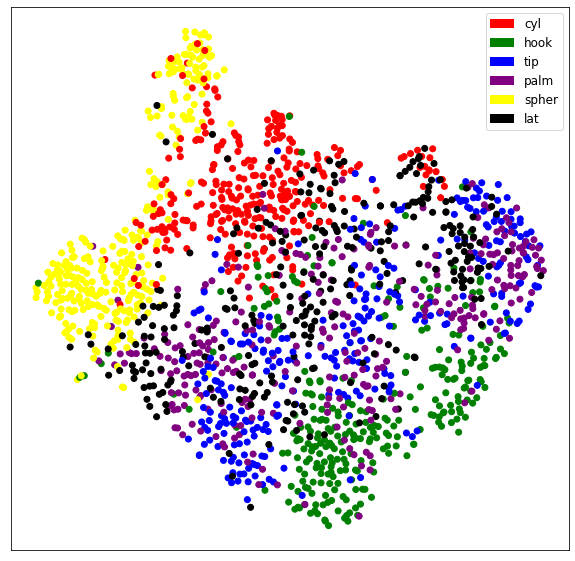

Feature Extraction Progress
session num: (out of 3) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 3 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.27393316427866615 mins
rms_window


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


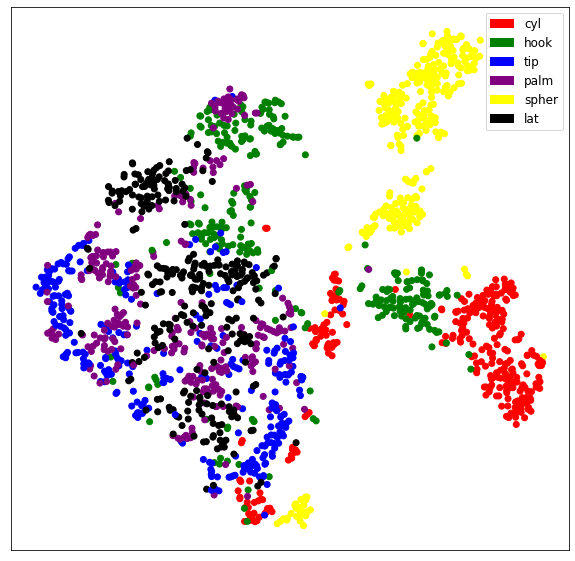

Feature Extraction Progress
session num: (out of 3) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 3 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.2954115668932597 mins
variance


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


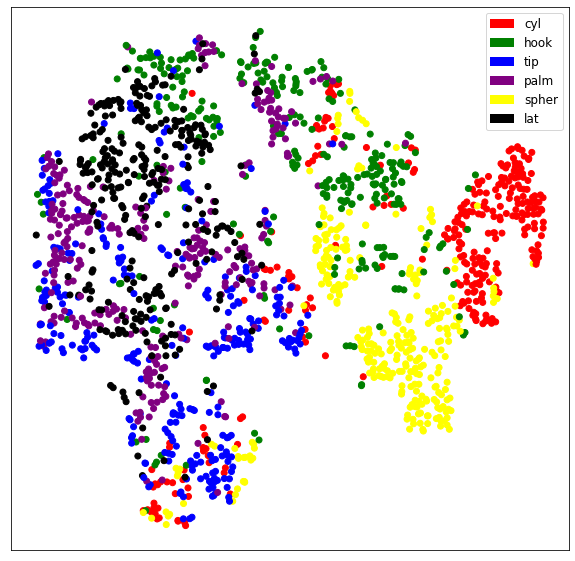

Feature Extraction Progress
session num: (out of 3) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 3 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.3940583864847819 mins
waveform_length


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


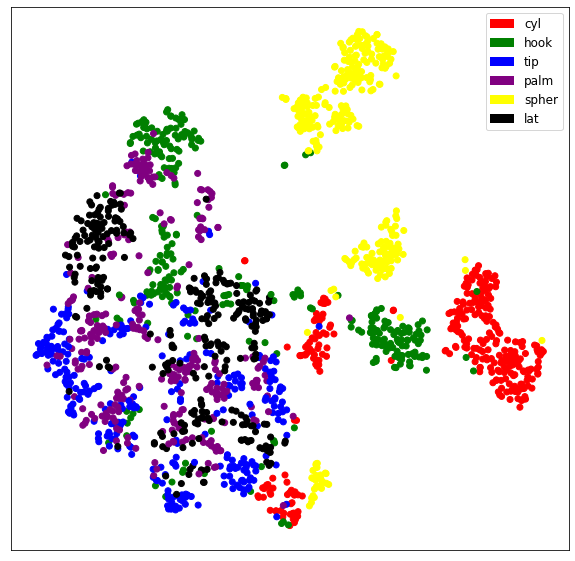

Feature Extraction Progress
session num: (out of 3) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 3 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.3219754974047343 mins
mean_absolute_value


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


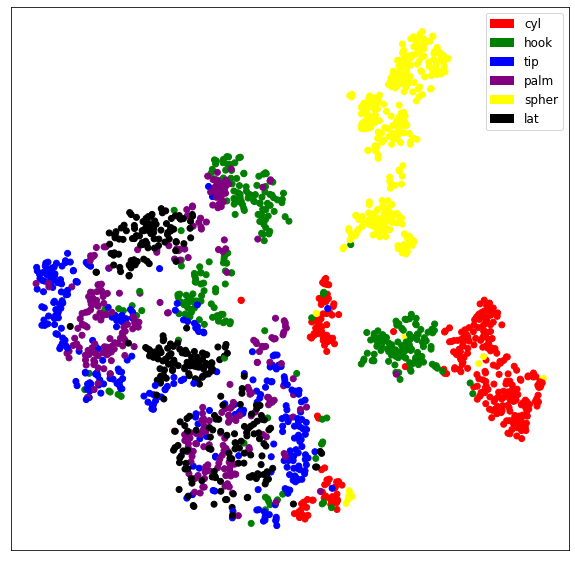

Feature Extraction Progress
session num: (out of 3) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 3 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.4556024392445882 mins
zero_crossing


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


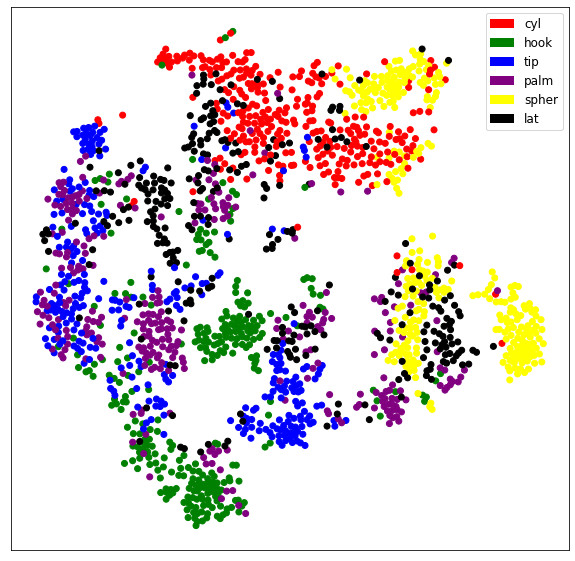

Feature Extraction Progress
session num: (out of 3) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 3) 3 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.48647454579671223 mins
sign_slope_changes


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


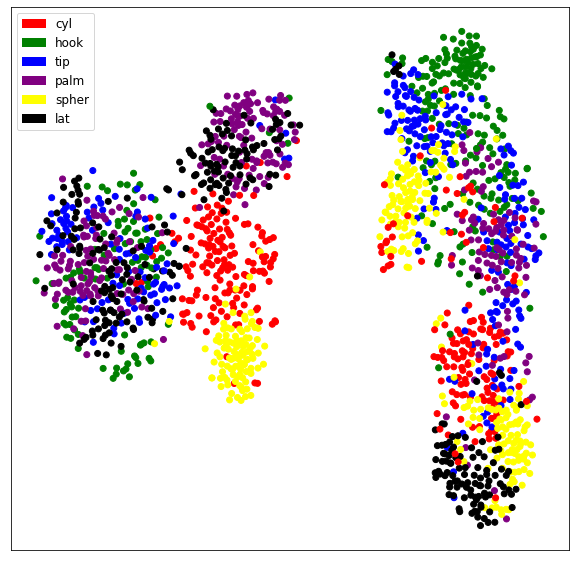

In [ ]:
num_trials = 100
num_sessions = 3 # one subject on three different days
for i in list_features:
  features_signals = feature_extraction(one_subject,feature_name_list=[i],window_length = 128, overlap_length = 64,
                                      ar_parameter = 6)
  x = combine_channels(features_signals,num_trials)
  y = get_combined_channel_classes(num_trials,num_sessions)
  print(i)
  visualization(x,y,num_classes=6,legend=True,method="tsne")

## 5 subject

In [ ]:
num_trials = 30
num_sessions = 5 # one subject on three different days
for i in all_features:
  features_signals = feature_extraction(processed_emg,feature_name_list=[i],window_length = 128, overlap_length = 64,
                                      ar_parameter = 11)
  x = combine_channels(features_signals,num_trials)
  y = get_combined_channel_classes(num_trials,num_sessions)
  print(i)
  visualization(x,y,num_classes=6,legend=True,method="tsne")

Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.4552064458529154 mins


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


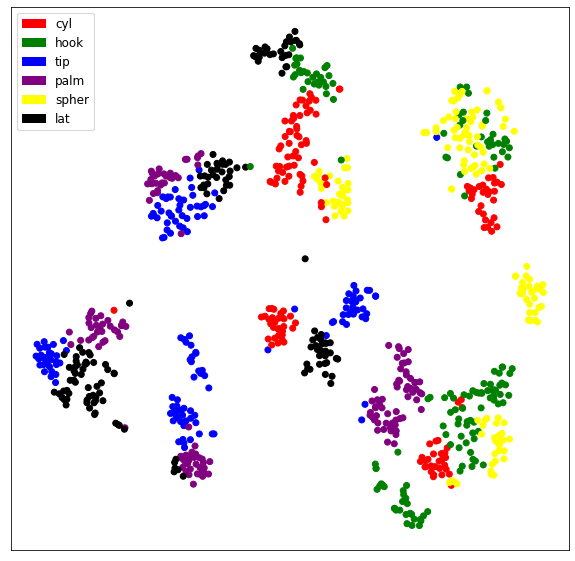

In [ ]:
num_trials = 30
num_sessions = 5 # five subject on three different days

features_signals = feature_extraction(five_subject,feature_name_list=list_features,window_length = 128, overlap_length = 64, ar_parameter = 11)
x = combine_channels(features_signals,num_trials)
y = get_combined_channel_classes(num_trials,num_sessions)
visualization(x,y,num_classes=6,legend=True,method="tsne")

In [ ]:
num_trials = 30
num_sessions = 5 # one subject on three different days
for i in all_features:
  features_signals = feature_extraction(five_subject,feature_name_list=[i],window_length = 128, overlap_length = 64,
                                      ar_parameter = 11)
  x = combine_channels(features_signals,num_trials)
  y = get_combined_channel_classes(num_trials,num_sessions)
  print(i)
  visualization(x,y,num_classes=6,legend=True,method="tsne")

Feature Extraction Progress
session num: (out of 5) 1 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 2 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 3 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 4 class num: (out of 12)  1
Feature Extraction Progress
session num: (out of 5) 5 class num: (out of 12)  1
Feature Extraction Total Runtime: 0.31027130683263143 mins


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


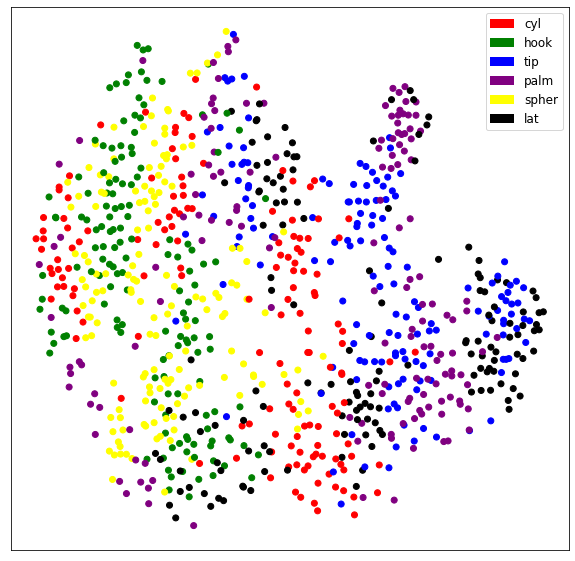

In [ ]:
num_trials = 30
num_sessions = 5 # one subject on three different days
features_signals = feature_extraction(five_subject,feature_name_list=['wilson_amplitude'],window_length = 128, overlap_length = 64, ar_parameter = 11)
x = combine_channels(features_signals,num_trials)
y = get_combined_channel_classes(num_trials,num_sessions)
visualization(x,y,num_classes=6,legend=True,method="tsne")

In [ ]:
print(len(processed_emg))
print(len(processed_emg[2]))
print(len(processed_emg[2]['spher_ch2'][0]))
print(len(five_subject))
print(len(five_subject[2]))
print(len(five_subject[2]['spher_ch2'][0]))
print(len(features_signals))
print(len(features_signals[2]))
# print(len(features_signals[2]['spher_ch2'][0]))

5
12
501
5
12
3000
1800
56


In [ ]:
x = combine_channels(processed_emg,num_trials)
y = get_combined_channel_classes(num_trials,num_sessions)
visualization(x,y,num_classes=6,legend=True,method="tsne")

IndexError: ignored

# Classify

In [ ]:

##################################################################################################################
# classifier functions
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, BernoulliNB, ComplementNB

def qda():

    return QuadraticDiscriminantAnalysis()

def lda():

    return LinearDiscriminantAnalysis()

def svm():

    return SVC(kernel = 'rbf') 

def random_forest():

    return RandomForestClassifier(random_state=5)

def extra_trees():

    return ExtraTreesClassifier(random_state = 10)

def grad_boost():
    
    return GradientBoostingClassifier(random_state = 8)

def gnb():

    return GaussianNB()

def mnb():
    
    return MultinomialNB()
    
def cat_nb():
    
    return CategoricalNB()

def bnb():
    
    return BernoulliNB

def comp_nb():
    
    return ComplementNB

def classification_train_test(all_signals_fearures_list, all_signals_classes, classifier_string = 'qda',dataset_type = "one_subject"):       
    '''
    This function takes a list of signals (represented by extracted features) and a list of the classes
    corresponding to each signal. Then this function trains the given classifier and
    tests the classifier on hold out data (last session or last subject depending on dataset).
    The test accuracy as well as a classification report is printed out.
    
    Note: classifier_strings are either qda,lda,svm, random forest, extra trees, and grad_boost
    '''
    if dataset_type == "one_subject":
        # test on third session, train on first two
        train_sigs, test_sigs, train_sigs_classes, test_sigs_classes = all_signals_fearures_list[:1199],all_signals_fearures_list[1200:], all_signals_classes[:1199], all_signals_classes[1200:]
   
    if dataset_type == "five_subjects":
        # test on last male subject, train on other four
        train_sigs, test_sigs, train_sigs_classes, test_sigs_classes = all_signals_fearures_list[:719],all_signals_fearures_list[720:],all_signals_classes[:719], all_signals_classes[720:]
    
    possibles = globals().copy()
    possibles.update(locals())
    method_to_call = possibles.get(classifier_string) # call function from feature name list
    clf = method_to_call()
    # selector = RFE(clf)
    selector = clf.fit(train_sigs, train_sigs_classes)

    prediction_classes = clf.predict(test_sigs) # testing the classifier
    actual_classes = test_sigs_classes 
    
    print("Baseline Random is 16.7%",end="\n")
    print("Accuracy on test set is: ",round(accuracy_score(prediction_classes, actual_classes),2)*100,"%",end="\n")
    print(classification_report(actual_classes,prediction_classes))
    # print(selector.ranking_)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # sklearn gives future warning which is not relevant here
classifier_list = ['qda','lda', 'svm', 'random_forest', 'extra_trees', 'grad_boost', 'gnb']
for i in classifier_list:
  ti = time.time() # time the feature extraction process
  print(i)
  classification_train_test(x,y, classifier_string = i, dataset_type = "five_subjects")

qda
Baseline Random is 16.7%
Accuracy on test set is:  22.0 %
              precision    recall  f1-score   support

         cyl       0.36      0.27      0.31        30
        hook       0.00      0.00      0.00        30
         lat       0.00      0.00      0.00        30
        palm       0.33      0.07      0.11        30
       spher       0.32      0.27      0.29        30
         tip       0.21      0.70      0.32        30

    accuracy                           0.22       180
   macro avg       0.20      0.22      0.17       180
weighted avg       0.20      0.22      0.17       180

lda
Baseline Random is 16.7%
Accuracy on test set is:  53.0 %
              precision    recall  f1-score   support

         cyl       0.73      0.27      0.39        30
        hook       0.41      0.80      0.55        30
         lat       0.00      0.00      0.00        30
        palm       0.61      0.37      0.46        30
       spher       0.86      0.80      0.83        30
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Baseline Random is 16.7%
Accuracy on test set is:  26.0 %
              precision    recall  f1-score   support

         cyl       0.75      0.80      0.77        30
        hook       0.16      0.17      0.16        30
         lat       0.17      0.03      0.06        30
        palm       0.05      0.03      0.04        30
       spher       0.28      0.33      0.30        30
         tip       0.10      0.17      0.12        30

    accuracy                           0.26       180
   macro avg       0.25      0.26      0.24       180
weighted avg       0.25      0.26      0.24       180

extra_trees
Baseline Random is 16.7%
Accuracy on test set is:  33.0 %
              precision    recall  f1-score   support

         cyl       0.69      0.90      0.78        30
        hook       0.00      0.00      0.00        30
         lat       0.40      0.13      0.20        30
        palm       0.08      0.03      0.05        30
       spher       0.20      0.40      0.27        30
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Feature Selection

In [ ]:
from sklearn.feature_selection import chi2, RFE
def feature_selection(all_signals_fearures_list, all_signals_classes,dataset_type = "one_subject"):       
    '''
    This function takes a list of signals (represented by extracted features) and a list of the classes
    corresponding to each signal. Then this function trains the given classifier and
    tests the classifier on hold out data (last session or last subject depending on dataset).
    The test accuracy as well as a classification report is printed out.
    
    Note: classifier_strings are either qda,lda,svm, random forest, extra trees, and grad_boost
    '''
    if dataset_type == "one_subject":
        # test on third session, train on first two
        train_sigs, test_sigs, train_sigs_classes, test_sigs_classes = all_signals_fearures_list[:1199],all_signals_fearures_list[1200:], all_signals_classes[:1199], all_signals_classes[1200:]
   
    if dataset_type == "five_subjects":
        # test on last male subject, train on other four
        train_sigs, test_sigs, train_sigs_classes, test_sigs_classes = all_signals_fearures_list[:719],all_signals_fearures_list[720:],all_signals_classes[:719], all_signals_classes[720:]
    
    # possibles = globals().copy()
    # possibles.update(locals())
    # method_to_call = possibles.get(classifier_string) # call function from feature name list
    # clf = method_to_call()
    # clf.fit(train_sigs, train_sigs_classes)
    result, values = RFE(train_sigs, train_sigs_classes)
    return(result, values)
    # prediction_classes = clf.predict(test_sigs) # testing the classifier
    # actual_classes = test_sigs_classes 
    
    # print("Baseline Random is 16.7%",end="\n")
    # print("Accuracy on test set is: ",round(accuracy_score(prediction_classes, actual_classes),2)*100,"%",end="\n")
    # print(classification_report(actual_classes,prediction_classes))

In [ ]:
feature_selection(x,y, dataset_type = "five_subjects")

TypeError: ignored